**1.Install and Import Dependencies**

**Install Dependencies**

In [1]:
!pip install easyocr
!pip install imutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 19.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

**2.Importing the Required Libraries**

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import easyocr

**3.Reading an Image**

**The image will be used to test the designed** **Automatic Number Plate Recognition System (ANPR)**

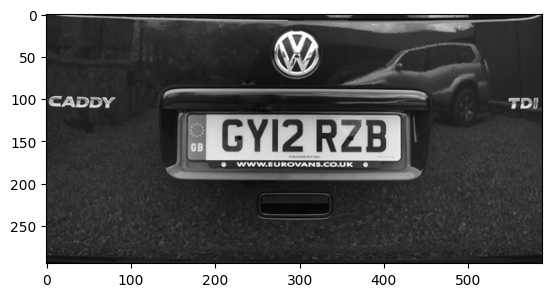

In [7]:
image = cv2.imread('/content/test.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

**4.Apply Sobel filter and find edges for localization**


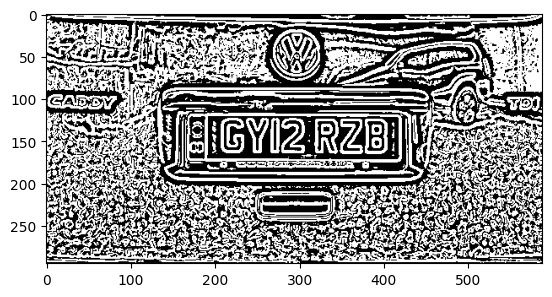

In [8]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply the Sobel operator in both horizontal and vertical directions
sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
# Combine the results from both directions
edged = cv2.addWeighted(cv2.convertScaleAbs(sobel_x), 0.5, cv2.convertScaleAbs(sobel_y), 0.5, 0)

    # Threshold the edges using adaptive thresholding
edged = cv2.adaptiveThreshold(edged, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

**5. Find Contours and Apply Mask**

In [9]:

contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area or other criteria
filtered_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 1000:  # Adjust the area threshold as needed
      filtered_contours.append(contour)

    # Sort contours by area
filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)[:10]

location = None

for contour in filtered_contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

    # Check if a valid contour was found

location

array([[[165, 125]],

       [[167, 182]],

       [[421, 171]],

       [[421, 119]]], dtype=int32)

In [10]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)

        # Bitwise AND to get the segment with the license plate
new_image = cv2.bitwise_and(image, image, mask=mask)

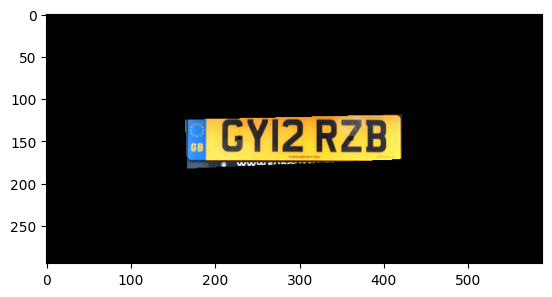

In [ ]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [11]:
(x, y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+3, y1:y2+3]

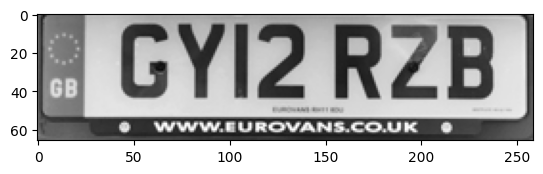

In [12]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

**6. Use Easy OCR To Read Text**

In [13]:

reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

[([[38, 0], [246, 0], [246, 54], [38, 54]], 'GYI2 RZB', 0.8925390296062793),
 ([[164, 56], [190, 56], [190, 62], [164, 62]], 'I', 0.08946853651367803)]

**7. Render Result**

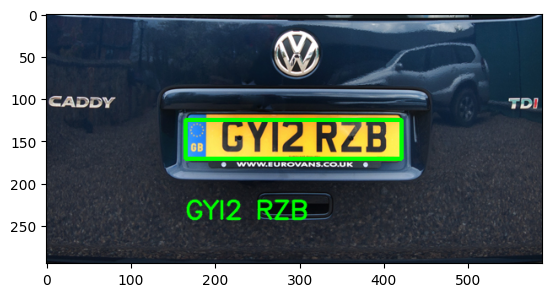

In [15]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(image, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(image, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))